## Compare CERES readout

In [1]:
import pathlib
import pandas as pd
import plotnine as gg

import mygene

In [2]:
output_dir = pathlib.Path("figures")
output_dir.mkdir(exist_ok=True)
cell_health_dir = pathlib.Path("../../1.calculate-metrics/cell-health/results")

In [3]:
# Load cell health grit scores
cell_health_grit_file = pathlib.Path(f"{cell_health_dir}/cell_health_grit.tsv")

cell_health_grit_df = (
    pd.read_csv(cell_health_grit_file, sep="\t")
    .query("cor_method == 'pearson'")
    .query("grit_replicate_summary_method == 'mean'")
)

print(cell_health_grit_df.shape)
cell_health_grit_df.head()

(714, 7)


,perturbation,group,grit,cell_line,barcode_control,cor_method,grit_replicate_summary_method
0,AKT1-1,AKT1,0.793952,HCC44,cutting_control,pearson,mean
1,AKT1-2,AKT1,0.775840,HCC44,cutting_control,pearson,mean
2,ARID1B-1,ARID1B,0.448876,HCC44,cutting_control,pearson,mean
3,ARID1B-2,ARID1B,0.323462,HCC44,cutting_control,pearson,mean
4,ATF4-1,ATF4,0.214374,HCC44,cutting_control,pearson,mean


In [4]:
mg = mygene.MyGeneInfo()

result = mg.querymany(
    cell_health_grit_df.group.unique().tolist(),
    scopes="symbol",
    species="human",
    fields="entrezgene,symbol,ensembl.gene,",
    as_dataframe=True,
)

ncbi_id_df = (
    result.drop_duplicates(subset="_id").loc[:, ["_id"]].reset_index(drop=False)
)
ncbi_id_df.head(2)

querying 1-59...done.
Finished.
7 input query terms found no hit:
	['ATP50', 'BRAF1', 'Chr2', 'EMPTY', 'LacZ', 'Luc', 'XBP']
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


,query,_id
0,AKT1,207
1,ARID1B,57492


In [5]:
cell_health_grit_df = cell_health_grit_df.merge(
    ncbi_id_df, left_on="group", right_on="query", how="left"
)

print(cell_health_grit_df.shape)
cell_health_grit_df.head(2)

(714, 9)


,perturbation,group,grit,cell_line,barcode_control,cor_method,grit_replicate_summary_method,query,_id
0,AKT1-1,AKT1,0.793952,HCC44,cutting_control,pearson,mean,AKT1,207
1,AKT1-2,AKT1,0.775840,HCC44,cutting_control,pearson,mean,AKT1,207


In [6]:
# Load ceres data
ceres_dir = pathlib.Path("../../0.download-data/data/")
ceres_file = pathlib.Path(f"{ceres_dir}/ceres.csv")
depmap_sample_file = pathlib.Path(f"{ceres_dir}/depmap_sample_info.csv")

ceres_df = pd.read_csv(ceres_file, index_col=0)
depmap_sample_df = pd.read_csv(depmap_sample_file, index_col=0)

In [7]:
hgnc = [x.split(" ")[0] for x in ceres_df.columns]
ncbi_gene_id = [x.split(" ")[1].strip("()") for x in ceres_df.columns]
ncbi_gene_id

['1',
 '29974',
 '2',
 '144568',
 '127550',
 '53947',
 '51146',
 '8086',
 '65985',
 '13',
 '344752',
 '126767',
 '343066',
 '51166',
 '195827',
 '79719',
 '22848',
 '28971',
 '14',
 '15',
 '25980',
 '441376',
 '16',
 '57505',
 '80755',
 '132949',
 '60496',
 '10157',
 '26574',
 '9625',
 '18',
 '19',
 '10349',
 '26154',
 '154664',
 '20',
 '21',
 '24',
 '23461',
 '23460',
 '10347',
 '10351',
 '10350',
 '5243',
 '23456',
 '8647',
 '5244',
 '340273',
 '10058',
 '22',
 '11194',
 '23457',
 '4363',
 '89845',
 '85320',
 '94160',
 '1244',
 '8714',
 '10257',
 '10057',
 '368',
 '6833',
 '10060',
 '215',
 '225',
 '5825',
 '5826',
 '6059',
 '23',
 '10061',
 '55324',
 '9619',
 '9429',
 '64137',
 '64240',
 '64241',
 '84696',
 '55347',
 '83451',
 '26090',
 '145447',
 '84945',
 '25864',
 '84836',
 '116236',
 '7920',
 '140701',
 '81926',
 '51104',
 '58489',
 '80167',
 '11057',
 '171586',
 '63874',
 '51099',
 '57406',
 '79575',
 '10006',
 '10152',
 '51225',
 '25890',
 '25',
 '27',
 '3983',
 '84448',
 '228

In [8]:
ceres_df.columns

Index(['A1BG (1)', 'A1CF (29974)', 'A2M (2)', 'A2ML1 (144568)',
       'A3GALT2 (127550)', 'A4GALT (53947)', 'A4GNT (51146)', 'AAAS (8086)',
       'AACS (65985)', 'AADAC (13)',
       ...
       'ZWILCH (55055)', 'ZWINT (11130)', 'ZXDA (7789)', 'ZXDB (158586)',
       'ZXDC (79364)', 'ZYG11A (440590)', 'ZYG11B (79699)', 'ZYX (7791)',
       'ZZEF1 (23140)', 'ZZZ3 (26009)'],
      dtype='object', length=18119)

In [9]:
# Clean gene name column
hgnc = [x.split(" ")[0] for x in ceres_df.columns]
ncbi_gene_id = [x.split(" ")[1].strip("()") for x in ceres_df.columns]

ceres_genes_df = (
    pd.DataFrame([hgnc, ncbi_gene_id], index=["HGNC", "NCBI"])
    .transpose()
    .sort_values(by="HGNC")
    .reset_index(drop=True)
)

# Set column names to NCBI
ceres_df.columns = ncbi_gene_id

ceres_genes_df.head(3)

,HGNC,NCBI
0,A1BG,1
1,A1CF,29974
2,A2M,2


In [10]:
# Merge the data
ceres_df = depmap_sample_df.merge(
    ceres_df, left_index=True, right_index=True, how="right"
)

print(ceres_df.shape)
ceres_df.head(3)

(789, 18143)


,stripped_cell_line_name,CCLE_Name,Alias,COSMICID,sex,source,Achilles_n_replicates,cell_line_NNMD,culture_type,culture_medium,...,55055,11130,7789,158586,79364,440590,79699,7791,23140,26009
DepMap_ID,,,,,,,,,,,,,,,,,,,,,
ACH-000004,HEL,HEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,907053.0,Male,DSMZ,2.0,-3.079202,Suspension,RPMI + 10% FBS,...,-0.124640,-0.467130,NaN,NaN,0.255396,0.239990,-0.408827,0.290927,0.224651,-0.135151
ACH-000005,HEL9217,HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,NaN,Male,ATCC,2.0,-2.404409,Suspension,RPMI + 10% FBS,...,-0.199184,-0.411868,-0.160226,-0.066143,0.223034,-0.076115,-0.102586,0.073836,0.026112,-0.250565
ACH-000007,LS513,LS513_LARGE_INTESTINE,NaN,907795.0,Male,ATCC,2.0,-2.586708,Adherent,RPMI + 10% FBS,...,-0.094879,-0.277592,-0.051759,0.119408,0.213447,-0.010327,-0.351529,0.085902,-0.392298,-0.440062


In [11]:
cell_lines = cell_health_grit_df.cell_line.unique().tolist()
assert all([x in ceres_df.stripped_cell_line_name.tolist() for x in cell_lines])

In [12]:
cols = ["stripped_cell_line_name"] + cell_health_grit_df._id.dropna().unique().tolist()
ceres_subset_df = (
    ceres_df.query("stripped_cell_line_name in @cell_lines")
    .loc[:, cols]
    .reset_index()
    .melt(
        id_vars=["DepMap_ID", "stripped_cell_line_name"],
        var_name="_id",
        value_name="ceres_score",
    )
)

print(ceres_subset_df.shape)
ceres_subset_df.head(3)

(156, 4)


,DepMap_ID,stripped_cell_line_name,_id,ceres_score
0,ACH-000667,HCC44,207,-0.122035
1,ACH-000681,A549,207,0.057331
2,ACH-000906,ES2,207,0.107984


In [13]:
cell_health_results_df = cell_health_grit_df.merge(
    ceres_subset_df,
    left_on=["_id", "cell_line"],
    right_on=["_id", "stripped_cell_line_name"],
    how="left",
)

cell_health_results_df = cell_health_results_df.merge(
    (
        cell_health_results_df.groupby(["cell_line", "group"])["grit"]
        .mean()
        .reset_index()
        .rename({"grit": "grit_mean"}, axis="columns")
    ),
    left_on=["cell_line", "group"],
    right_on=["cell_line", "group"],
    how="left",
).sort_values(by="grit", ascending=False)

print(cell_health_results_df.shape)
cell_health_results_df.head(3)

(714, 13)


,perturbation,group,grit,cell_line,barcode_control,cor_method,grit_replicate_summary_method,query,_id,DepMap_ID,stripped_cell_line_name,ceres_score,grit_mean
63,ITGAV-2,ITGAV,3.899438,HCC44,cutting_control,pearson,mean,ITGAV,3685,ACH-000667,HCC44,-1.076603,3.706793
62,ITGAV-1,ITGAV,3.775598,HCC44,cutting_control,pearson,mean,ITGAV,3685,ACH-000667,HCC44,-1.076603,3.706793
676,MYC-1,MYC,3.714287,ES2,perturbation_control,pearson,mean,MYC,4609,ACH-000906,ES2,-1.918112,3.488120


/Users/akalinin/Software/miniconda3/envs/grit-benchmark/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6 x 3.5 in image.
/Users/akalinin/Software/miniconda3/envs/grit-benchmark/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: figures/cell_health_grit_ceres_comparison.png
/Users/akalinin/Software/miniconda3/envs/grit-benchmark/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 120 rows containing missing values.
/Users/akalinin/Software/miniconda3/envs/grit-benchmark/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 120 rows containing missing values.


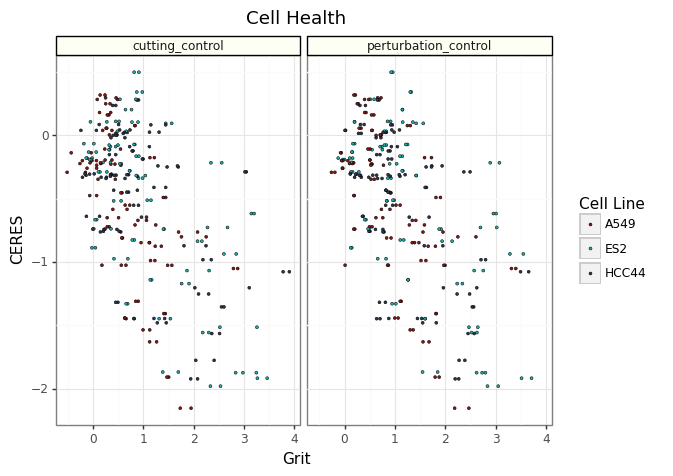

<ggplot: (684956045)>

In [14]:
cell_line_colors = {"A549": "#861613", "ES2": "#1CADA8", "HCC44": "#2A364D"}

grit_ceres_comparison_gg = (
    gg.ggplot(cell_health_results_df, gg.aes(x="grit", y="ceres_score"))
    + gg.geom_point(gg.aes(fill="cell_line"), size=1, stroke=0.2)
    + gg.scale_fill_manual(name="Cell Line", values=cell_line_colors)
    + gg.theme_bw()
    + gg.xlab("Grit")
    + gg.ylab("CERES")
    + gg.ggtitle("Cell Health")
    + gg.facet_wrap("~barcode_control", ncol=2)
    + gg.theme(strip_background=gg.element_rect(color="black", fill="#fdfff4"))
)

output_file = pathlib.Path(f"{output_dir}/cell_health_grit_ceres_comparison.png")
grit_ceres_comparison_gg.save(output_file, dpi=500, height=3.5, width=6)

grit_ceres_comparison_gg

In [15]:
(
    cell_health_results_df.query("ceres_score > -1.1")
    .query("grit_mean > 2")
    .query("barcode_control == 'cutting_control'")
    .sort_values(by="ceres_score", ascending=False)
    .reset_index(drop=True)
)

,perturbation,group,grit,cell_line,barcode_control,cor_method,grit_replicate_summary_method,query,_id,DepMap_ID,stripped_cell_line_name,ceres_score,grit_mean
0,ITGAV-2,ITGAV,2.555547,ES2,cutting_control,pearson,mean,ITGAV,3685,ACH-000906,ES2,-0.215508,2.716326
1,ITGAV-1,ITGAV,2.340666,ES2,cutting_control,pearson,mean,ITGAV,3685,ACH-000906,ES2,-0.215508,2.716326
2,RHOA-1,RHOA,3.044648,HCC44,cutting_control,pearson,mean,RHOA,387,ACH-000667,HCC44,-0.287301,2.730328
3,RHOA-2,RHOA,3.016001,HCC44,cutting_control,pearson,mean,RHOA,387,ACH-000667,HCC44,-0.287301,2.730328
4,MAPK1-1,MAPK1,3.198469,ES2,cutting_control,pearson,mean,MAPK1,5594,ACH-000906,ES2,-0.616920,3.076885
5,MAPK1-2,MAPK1,3.143739,ES2,cutting_control,pearson,mean,MAPK1,5594,ACH-000906,ES2,-0.616920,3.076885
6,RHOA-2,RHOA,2.670339,ES2,cutting_control,pearson,mean,RHOA,387,ACH-000906,ES2,-0.726909,2.666190
7,RHOA-1,RHOA,2.272015,ES2,cutting_control,pearson,mean,RHOA,387,ACH-000906,ES2,-0.726909,2.666190
8,PTK2-2,PTK2,2.246788,A549,cutting_control,pearson,mean,PTK2,5747,ACH-000681,A549,-0.800656,2.215323
9,PTK2-1,PTK2,1.755580,A549,cutting_control,pearson,mean,PTK2,5747,ACH-000681,A549,-0.800656,2.215323


In [16]:
# What are the perturbations with high grit and low ceres scores?
(
    cell_health_results_df.query("grit > 2")
    .query("ceres_score > -1")
    .query("barcode_control == 'cutting_control'")
    .sort_values(by="ceres_score")
    .reset_index(drop=True)
)

,perturbation,group,grit,cell_line,barcode_control,cor_method,grit_replicate_summary_method,query,_id,DepMap_ID,stripped_cell_line_name,ceres_score,grit_mean
0,PTK2-2,PTK2,2.348093,HCC44,cutting_control,pearson,mean,PTK2,5747,ACH-000667,HCC44,-0.981299,2.510100
1,PTK2-1,PTK2,2.181449,HCC44,cutting_control,pearson,mean,PTK2,5747,ACH-000667,HCC44,-0.981299,2.510100
2,GPX4-1,GPX4,2.843310,ES2,cutting_control,pearson,mean,GPX4,2879,ACH-000906,ES2,-0.935900,3.069336
3,GPX4-2,GPX4,2.598490,ES2,cutting_control,pearson,mean,GPX4,2879,ACH-000906,ES2,-0.935900,3.069336
4,CSNK1A1-1,CSNK1A1,2.242948,HCC44,cutting_control,pearson,mean,CSNK1A1,1452,ACH-000667,HCC44,-0.871167,1.895637
5,CDK2-2,CDK2,2.160147,ES2,cutting_control,pearson,mean,CDK2,1017,ACH-000906,ES2,-0.835286,2.077230
6,CDK2-1,CDK2,2.075048,ES2,cutting_control,pearson,mean,CDK2,1017,ACH-000906,ES2,-0.835286,2.077230
7,PTK2-2,PTK2,2.246788,A549,cutting_control,pearson,mean,PTK2,5747,ACH-000681,A549,-0.800656,2.215323
8,CSNK1A1-1,CSNK1A1,2.075395,A549,cutting_control,pearson,mean,CSNK1A1,1452,ACH-000681,A549,-0.763007,1.821224
9,RHOA-1,RHOA,2.272015,ES2,cutting_control,pearson,mean,RHOA,387,ACH-000906,ES2,-0.726909,2.666190


In [17]:
control_compare_df = cell_health_results_df.pivot(
    index=["perturbation", "group", "cell_line", "ceres_score"],
    columns=["barcode_control"],
    values="grit",
).reset_index(drop=False)

control_compare_df.head()

barcode_control,perturbation,group,cell_line,ceres_score,cutting_control,perturbation_control
0,AKT1-1,AKT1,A549,0.057331,0.257727,0.327723
1,AKT1-1,AKT1,ES2,0.107984,-0.052501,0.196828
2,AKT1-1,AKT1,HCC44,-0.122035,0.793952,0.867435
3,AKT1-2,AKT1,A549,0.057331,0.271111,0.289317
4,AKT1-2,AKT1,ES2,0.107984,0.272555,0.197591


/Users/akalinin/Software/miniconda3/envs/grit-benchmark/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 4 x 3.5 in image.
/Users/akalinin/Software/miniconda3/envs/grit-benchmark/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: figures/cell_health_barcode_control_comparison.png
/Users/akalinin/Software/miniconda3/envs/grit-benchmark/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 18 rows containing missing values.
/Users/akalinin/Software/miniconda3/envs/grit-benchmark/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 18 rows containing missing values.


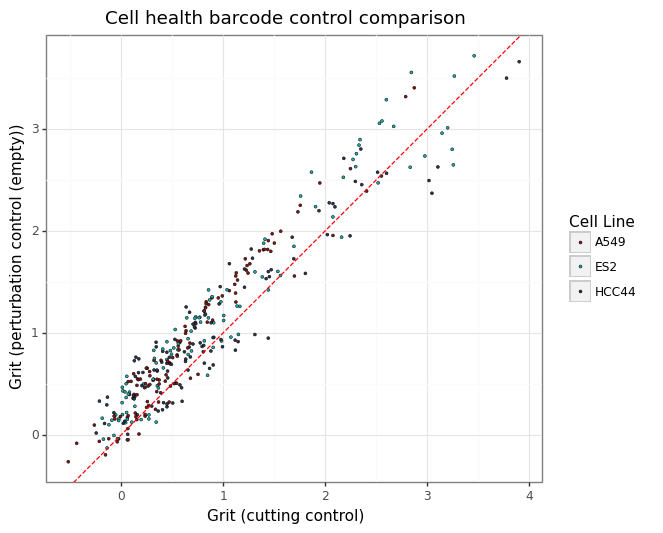

<ggplot: (684955709)>

In [18]:
grit_barcode_comparison_gg = (
    gg.ggplot(control_compare_df, gg.aes(x="cutting_control", y="perturbation_control"))
    + gg.geom_point(gg.aes(fill="cell_line"), size=1, stroke=0.2)
    + gg.scale_fill_manual(name="Cell Line", values=cell_line_colors)
    + gg.theme_bw()
    + gg.xlab("Grit (cutting control)")
    + gg.ylab("Grit (perturbation control (empty))")
    + gg.ggtitle("Cell health barcode control comparison")
    + gg.geom_abline(intercept=0, slope=1, linetype="dashed", color="red")
    + gg.coord_fixed()
)

output_file = pathlib.Path(f"{output_dir}/cell_health_barcode_control_comparison.png")
grit_barcode_comparison_gg.save(output_file, dpi=500, height=3.5, width=4)

grit_barcode_comparison_gg